In [1]:
# Import Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve, precision_score
)
from sklearn.neural_network import MLPClassifier
import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Step 1: Load the Breast Cancer Dataset
print("Loading Breast Cancer Dataset...")
cancer = load_breast_cancer()
df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
df['target'] = cancer.target
print("Dataset loaded successfully!")

Loading Breast Cancer Dataset...
Dataset loaded successfully!


In [3]:
df.columns

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension',
       'target'],
      dtype='object')

In [4]:
# Step 2: Exploratory Data Analysis (EDA)
print("\nPerforming Exploratory Data Analysis...")
print("\nDataset Overview:")
df.head()


Performing Exploratory Data Analysis...

Dataset Overview:


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [5]:
print("\nSummary Statistics:")
print(df.describe())


Summary Statistics:
       mean radius  mean texture  mean perimeter    mean area  \
count   569.000000    569.000000      569.000000   569.000000   
mean     14.127292     19.289649       91.969033   654.889104   
std       3.524049      4.301036       24.298981   351.914129   
min       6.981000      9.710000       43.790000   143.500000   
25%      11.700000     16.170000       75.170000   420.300000   
50%      13.370000     18.840000       86.240000   551.100000   
75%      15.780000     21.800000      104.100000   782.700000   
max      28.110000     39.280000      188.500000  2501.000000   

       mean smoothness  mean compactness  mean concavity  mean concave points  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813        0.079720             0.038803   
min           0.052630          0.019380        0.000000             

In [6]:
# Step 3: Check for Missing Values
print("\nChecking for Missing Values...")
missing_values = df.isnull().sum().sum()
if missing_values == 0:
    print("No missing values found!")
else:
    print(f"Found {missing_values} missing values. Please address them.")


Checking for Missing Values...
No missing values found!


In [7]:
# Remove duplicate rows, if any
initial_rows = df.shape[0]
df = df.drop_duplicates()
final_rows = df.shape[0]
print(f"Removed {initial_rows - final_rows} duplicate rows.")

Removed 0 duplicate rows.


In [8]:
# Handle outliers using the IQR method
for col in df.select_dtypes(include=[np.number]).columns[:-1]:  # Exclude 'target'
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)

In [10]:
# Step 4: Data Preparation
print("\nPreparing Data...")
X = df.drop(['target'], axis=1)
y = df['target']

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
print("Data split into train and test sets.")

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Save the scaler to a pickle file
scaler_path = r"C:/Users/91628/Desktop/Assignment/scaler.pkl"
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"Scaler saved at: {scaler_path}")


Preparing Data...
Data split into train and test sets.
Scaler saved at: C:/Users/91628/Desktop/Assignment/scaler.pkl


In [11]:
# Step 5: Feature Selection
print("\nPerforming Feature Selection...")
selector = SelectKBest(f_classif, k=10)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)
selected_features = X.columns[selector.get_support()]
print("Selected Features:", selected_features)


Performing Feature Selection...
Selected Features: Index(['mean radius', 'mean perimeter', 'mean area', 'mean concavity',
       'mean concave points', 'area error', 'worst radius', 'worst perimeter',
       'worst area', 'worst concave points'],
      dtype='object')



Class Distribution:


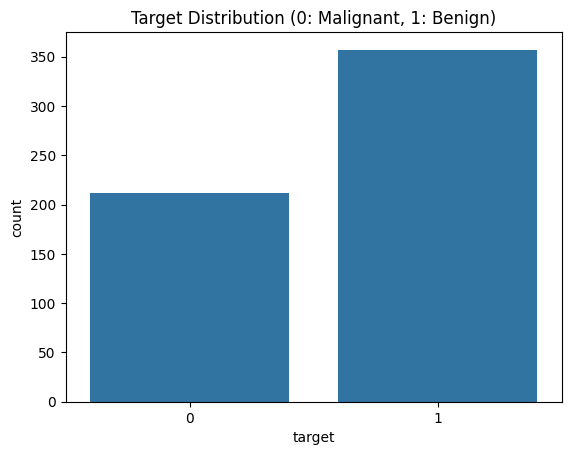

In [12]:
print("\nClass Distribution:")
sns.countplot(x='target', data=df)
plt.title("Target Distribution (0: Malignant, 1: Benign)")
plt.show()

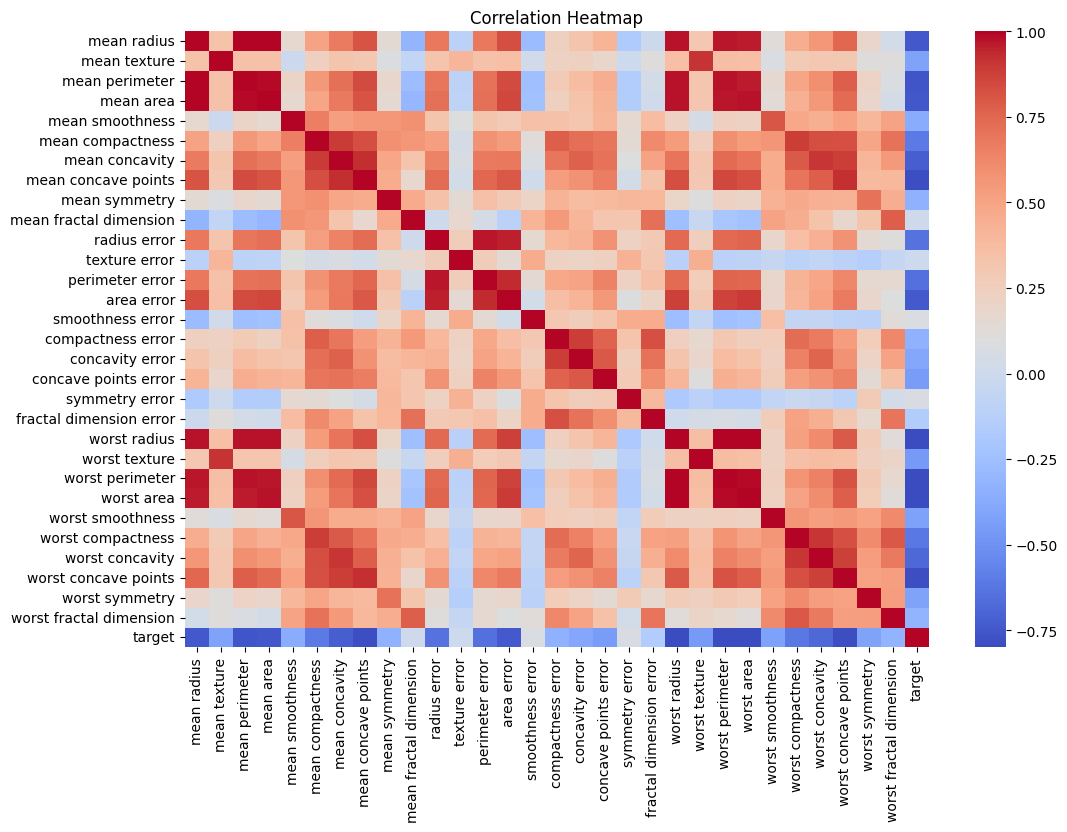

In [13]:
# Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), cmap="coolwarm", annot=False, cbar=True)
plt.title("Correlation Heatmap")
plt.show()

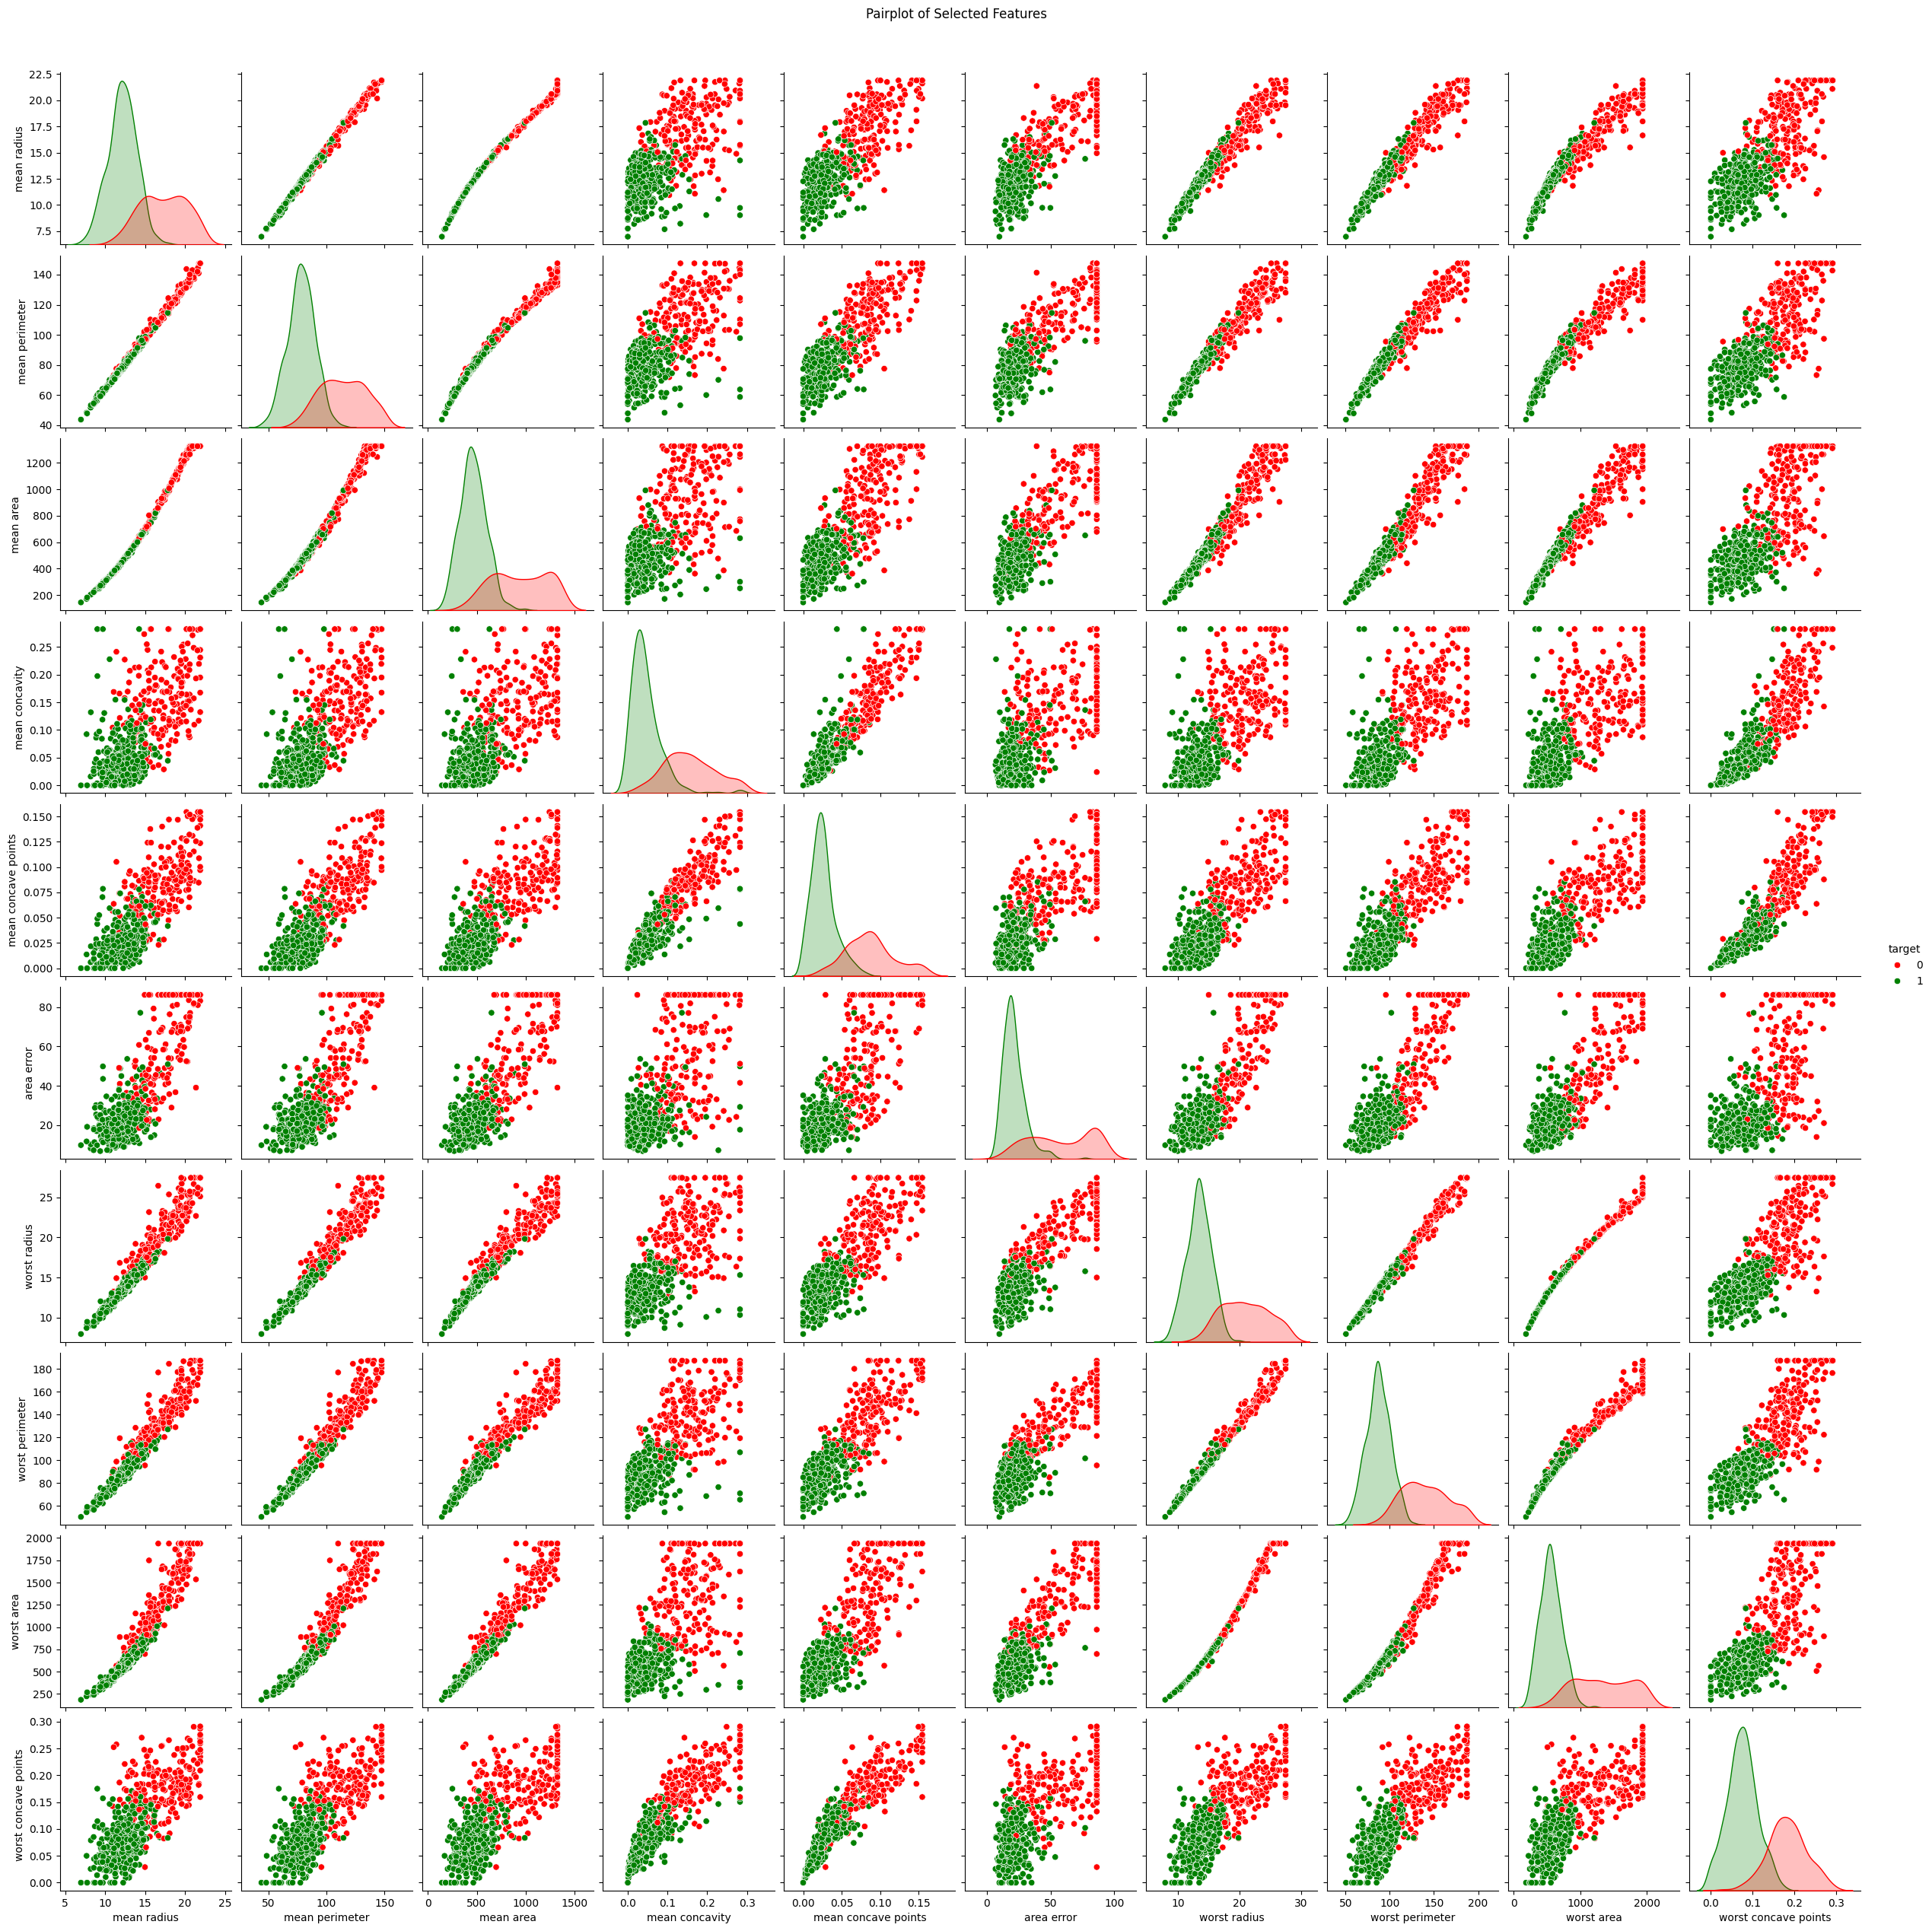

In [14]:
# 3. Pairplot of Selected Features
sns.pairplot(df, vars=selected_features, hue='target', palette=['red', 'green'], diag_kind='kde')
plt.suptitle("Pairplot of Selected Features", y=1.02)
plt.show()

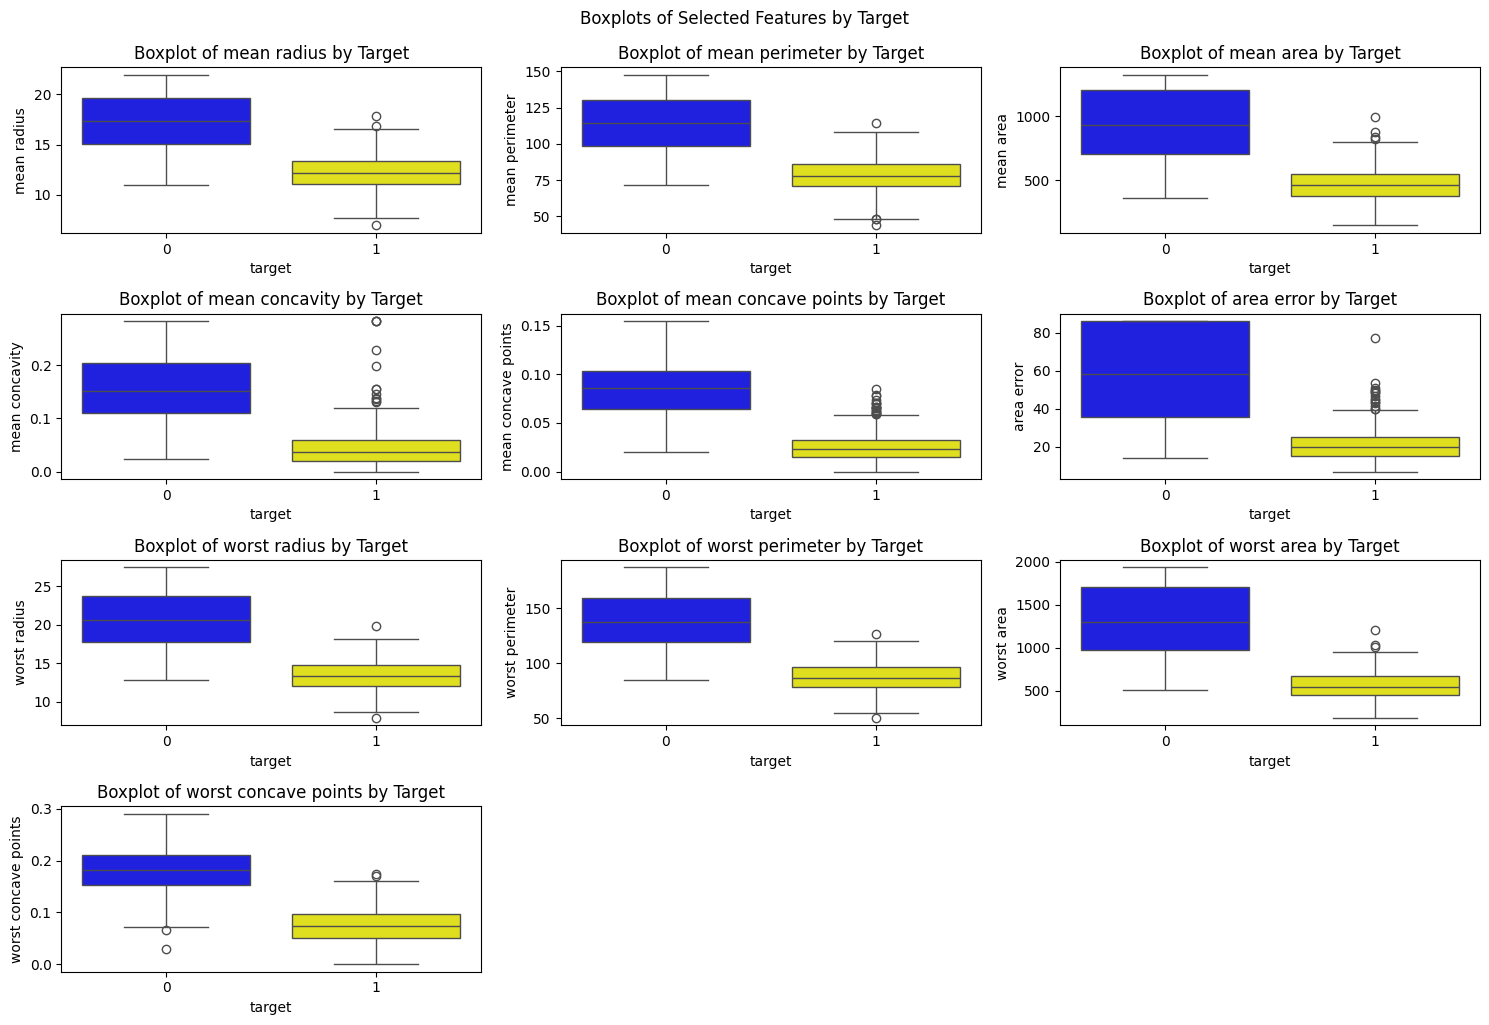

In [15]:
# Boxplots of Selected Features by Target
plt.figure(figsize=(15, 10))

# Calculate rows and columns dynamically
num_features = len(selected_features)
cols = 3
rows = (num_features + cols - 1) // cols  # Ceiling division to determine rows

for i, feature in enumerate(selected_features):
    plt.subplot(rows, cols, i + 1)
    sns.boxplot(x='target', y=feature, data=df, palette=['blue', 'yellow'])
    plt.title(f"Boxplot of {feature} by Target")
    plt.tight_layout()

plt.suptitle("Boxplots of Selected Features by Target", y=1.02)
plt.show()

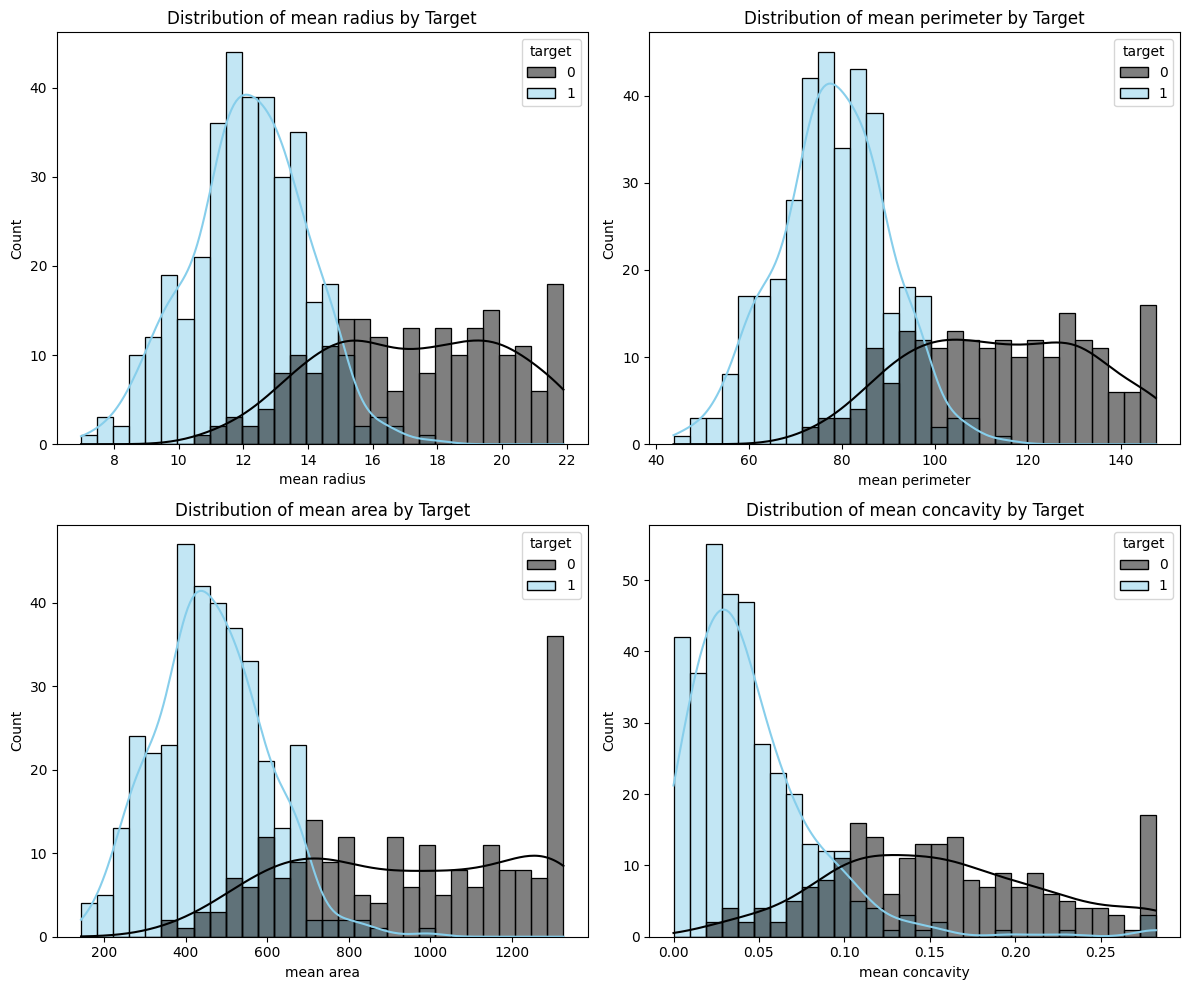

In [16]:
# 5. Distribution of Features
plt.figure(figsize=(12, 10))
for i, feature in enumerate(selected_features[:4]):  # Limit to 4 for visualization
    plt.subplot(2, 2, i + 1)
    sns.histplot(data=df, x=feature, hue='target', kde=True, palette=['black', 'skyblue'], bins=30)
    plt.title(f"Distribution of {feature} by Target")
    plt.xlabel(feature)
    plt.ylabel("Count")
plt.tight_layout()
plt.show()

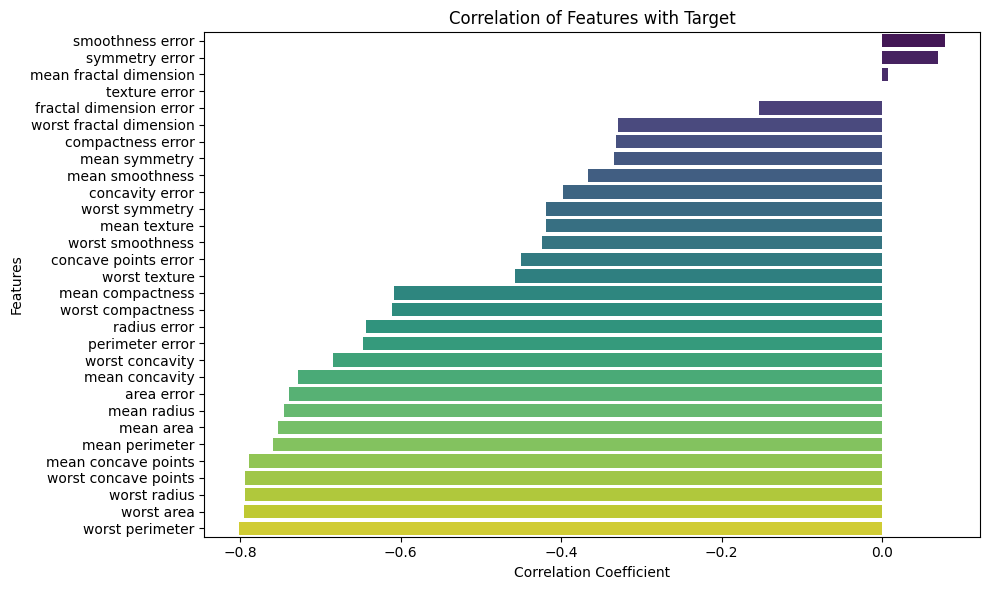

In [17]:
# 6. Correlation with Target Variable
plt.figure(figsize=(10, 6))

# Compute the correlation matrix
correlation_matrix = df.corr()

# Correlation of features with the target variable
target_corr = correlation_matrix['target'][:-1].sort_values(ascending=False)  # Exclude 'target'
sns.barplot(x=target_corr.values, y=target_corr.index, palette='viridis')

plt.title("Correlation of Features with Target")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

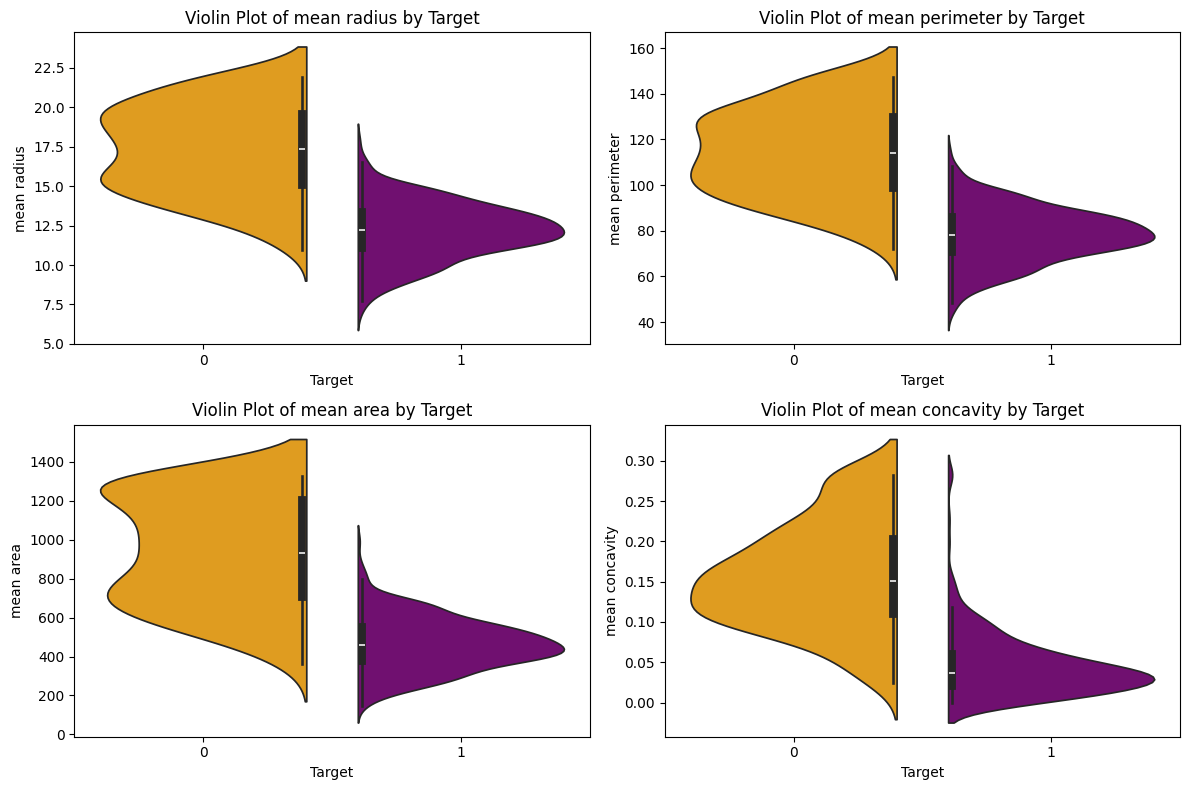

In [18]:
# 7. Violin Plot of Features
plt.figure(figsize=(12, 8))
for i, feature in enumerate(selected_features[:4]):
    plt.subplot(2, 2, i + 1)
    sns.violinplot(x='target', y=feature, data=df, palette=['orange', 'purple'], split=True)
    plt.title(f"Violin Plot of {feature} by Target")
    plt.xlabel("Target")
    plt.ylabel(feature)
plt.tight_layout()
plt.show()

In [19]:
# Step 6: Grid Search CV for Model Tuning
print("\nSetting up Grid Search CV for ANN...")
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['tanh', 'relu'],
    'solver': ['adam', 'sgd'],
    'max_iter': [1000, 2000]
}
mlp = MLPClassifier(random_state=42)
grid_search = GridSearchCV(mlp, param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_selected, y_train)
print("Best Parameters from Grid Search:", grid_search.best_params_)


Setting up Grid Search CV for ANN...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters from Grid Search: {'activation': 'tanh', 'hidden_layer_sizes': (50, 50), 'max_iter': 1000, 'solver': 'adam'}


In [20]:
# Step 7: Train and Evaluate the Best ANN Model
print("\nTraining the Best ANN Model...")
best_params = grid_search.best_params_
print(best_params)



Training the Best ANN Model...
{'activation': 'tanh', 'hidden_layer_sizes': (50, 50), 'max_iter': 1000, 'solver': 'adam'}


In [21]:
# Instantiate the MLPClassifier with the best parameters
model = MLPClassifier(
    activation='tanh', 
    hidden_layer_sizes=(50, 50), 
    max_iter=1000, 
    solver='adam',  # Include the solver parameter
    random_state=42
)

# Train the model
model.fit(X_train_selected, y_train)

MLPClassifier(activation='tanh', hidden_layer_sizes=(50, 50), max_iter=1000,
              random_state=42)

In [22]:
# Predictions and Metrics
y_pred = model.predict(X_test_selected)
print("\nModel Evaluation Metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Model Evaluation Metrics:
Accuracy: 0.9532163742690059
Precision: 0.9459459459459459
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.91      0.94        64
           1       0.95      0.98      0.96       107

    accuracy                           0.95       171
   macro avg       0.96      0.94      0.95       171
weighted avg       0.95      0.95      0.95       171



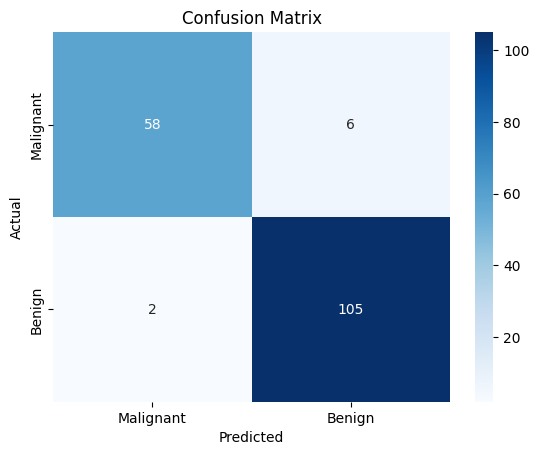

In [23]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=['Malignant', 'Benign'], yticklabels=['Malignant', 'Benign'])
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

In [24]:
# Save the best ANN model
model_path = r"C:/Users/91628/Desktop/Assignment/best_ann_model.pkl"
with open(model_path, 'wb') as f:
    pickle.dump(model, f)
print(f"Best ANN model saved at: {model_path}")



Best ANN model saved at: C:/Users/91628/Desktop/Assignment/best_ann_model.pkl



Generating ROC Curve...


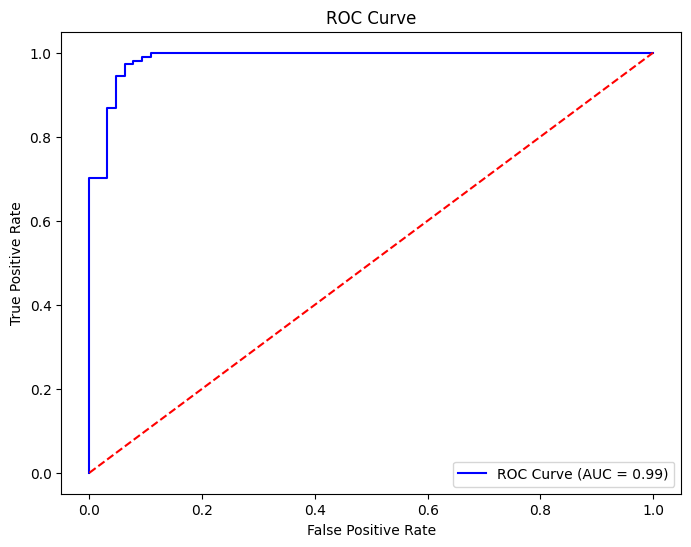

In [25]:
# Step 8: ROC Curve
print("\nGenerating ROC Curve...")
y_pred_proba = model.predict_proba(X_test_selected)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()
